# Allen Cahn

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/mindflow/zh_cn/physics_driven/mindspore_burgers1D.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/mindflow/zh_cn/physics_driven/mindspore_burgers1D.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/master/docs/mindflow/docs/source_zh_cn/physics_driven/burgers1D.ipynb)

本案例要求**MindSpore版本 >= 2.0.0**调用如下接口: *mindspore.jit，mindspore.jit_class，mindspore.jacrev*。

## 概述

计算流体动力学是21世纪流体力学领域最重要的技术之一。 通过数值方法求解流体力学控制方程，可以实现流动分析、预测和控制。 传统的有限元法（FEM）和有限差分法（FDM）由于仿真过程复杂（物理建模、网格划分、数值离散、迭代求解等）且计算成本较高，效率低下。 因此，有必要利用人工智能来提高流体模拟的效率。

近年来，在经典理论和具有计算机性能的数值方法发展趋于平稳的同时，机器学习方法将大量数据与神经网络相结合，实现了流场的快速模拟。 这些方法可以获得接近传统方法的精度，为流场求解提供了新的思路。

Allen-Cahn 方程（以 John W. Cahn 和 Sam Allen 命名）是数学物理的反应扩散方程，描述了多组分合金系统中的相分离过程，包括有序-无序转变。 该方程描述了域 $\Omega$ 上标量值状态变量 $\eta$ 在时间间隔 $T$ 内的时间演化。 本例中，MindFLow流体模拟套件用于基于物理驱动的PINNs（Physics INformed Neural Networks）方法求解Allen Cahn方程。

## 问题描述

Allen Cahn'方程的形式如下:

$$
\frac{\partial u}{\partial t} = \frac{\partial^2u}{\partial x^2} + 5(u - u^3), \quad x \in [-1, 1], \quad t \in [0, 1]
$$

本案例使用狄利克雷边界条件和初始条件，形式如下

$$
u(-1, t) = u(1, t) = -1
$$

$$
u(x, 0) = x^2\cos(\pi x)
$$

本案例利用PINNs方法学习位置和时间到相应物理量的映射$(x, t) \mapsto u$，实现Allen Cahn'方程的求解。

## 技术路径

MindFlow求解该问题的具体流程如下：

1. 创建数据集。
2. 构建模型。
3. 优化器。
4. Allen Cahn。
5. 模型训练。
6. 模型推理及可视化。

In [1]:

import time

import numpy as np

import mindspore
from mindspore import context, nn, ops, Tensor, jit, set_seed
from mindspore import dtype as mstype
from mindspore import load_checkpoint, load_param_into_net
from mindflow.pde import PDEWithLoss
from sympy import diff, symbols, Function

from mindflow.loss import get_loss_metric

下述`src`包可以在[pplications/physical_driven/allen_cahn/src/](https://gitee.com/mindspore/mindscience/tree/master/MindFlow/applications/physics_driven/allen_cahn/src)下载

In [2]:
from mindflow.pde import sympy_to_mindspore
from src import MultiScaleFCSequentialOutputTransform
from mindflow.utils import load_yaml_config

from src import create_training_dataset, create_test_dataset, visual, calculate_l2_error

set_seed(123456)
np.random.seed(123456)

In [3]:
# set context for training: using graph mode for high performance training with GPU acceleration
context.set_context(mode=context.GRAPH_MODE, device_target="GPU", device_id=0)
use_ascend = context.get_context(attr_key='device_target') == "Ascend"

In [4]:
# load configuration
config = load_yaml_config('./configs/allen_cahn_cfg.yaml')

## 创建数据集

本案例根据求解域、初始条件及边值条件进行随机采样，生成训练数据集与测试数据集，具体设置如下：

下载测试数据集： [physics_driven/allen_cahn/dataset] 。


In [5]:
# create training dataset
ac_train_dataset = create_training_dataset(config)
train_dataset = ac_train_dataset.create_dataset(batch_size=config["train_batch_size"],
                                                shuffle=True,
                                                prebatched_data=True,
                                                drop_remainder=True)
# create test dataset
inputs, label = create_test_dataset(config["test_dataset_path"])

## 构建模型

本例使用简单的全连接网络，深度为6层，激发函数为`tanh`函数。

In [ ]:
# define models and optimizers
model = MultiScaleFCSequentialOutputTransform(in_channels=config["model"]["in_channels"],
                                              out_channels=config["model"]["out_channels"],
                                              layers=config["model"]["layers"],
                                              neurons=config["model"]["neurons"],
                                              residual=config["model"]["residual"],
                                              act=config["model"]["activation"],
                                              num_scales=1)
if config["load_ckpt"]:
    param_dict = load_checkpoint(config["load_ckpt_path"])
    load_param_into_net(model, param_dict)

## 优化器

In [7]:
# define optimizer
optimizer = nn.Adam(model.trainable_params(),
                    config["optimizer"]["initial_lr"])

## Allen Cahn

下述`AllenCahn`将Allen Cahn问题同数据集关联起来，包含一个部分：控制方程。


In [8]:
class AllenCahn(PDEWithLoss):
    r"""
    Allen Cahn problem based on PDEWithLoss

    Args:
        model (Cell): network for training.
        loss_fn (str): Define the loss function. Default: mse.

    Supported Platforms:
        ``Ascend`` ``GPU``

    """

    def __init__(self, model, loss_fn="mse"):
        self.x, self.t = symbols("x t")
        self.u = Function("u")(self.x, self.t)
        self.in_vars = [self.x, self.t]
        self.out_vars = [self.u]
        if isinstance(loss_fn, str):
            self.loss_fn = get_loss_metric(loss_fn)
        else:
            self.loss_fn = loss_fn
        self.pde_nodes = sympy_to_mindspore(
            self.pde(), self.in_vars, self.out_vars)
        model.set_output_transform(self.output_transform)
        super(AllenCahn, self).__init__(model, self.in_vars, self.out_vars)

    def output_transform(self, x, out):
        """
        Define output transforma function in Allen Cahn Equation

        Args:
            x (Tensor): network input
            out (Tensor): network output
        """

        return x[:, 0:1] ** 2 * ops.cos(np.pi * x[:, 0:1]) + x[:, 1:2] * (1 - x[:, 0:1] ** 2) * out

    def force_function(self, u):
        """
        Define forcing function in Allen Cahn Equation

        Args:
            u (Tensor)
        """
        return 5 * (u - u ** 3)

    def pde(self):
        """
        Define Allen Cahn equation
        """

        d = 0.001
        loss_1 = (
            self.u.diff(self.t)
            - d * diff(self.u, (self.x, 2))
            - self.force_function(self.u)
        )
        return {"loss_1": loss_1}

    def get_loss(self, pde_data):
        """
        Compute loss of 3 parts: governing equation, initial condition and boundary conditions.

        Args:
            pde_data (Tensor): the input data of governing equations.
            ic_data (Tensor): the input data of initial condition.
            bc_data (Tensor): the input data of boundary condition.
        """
        pde_res = ops.Concat(1)(self.parse_node(
            self.pde_nodes, inputs=pde_data))
        pde_loss = self.loss_fn(
            pde_res, Tensor(np.array([0.0]).astype(np.float32), mstype.float32)
        )

        return pde_loss

## 模型训练

使用**MindSpore >= 2.0.0**的版本，可以使用函数式编程范式训练神经网络。

In [9]:
def train():
    '''Train and evaluate the network'''
    problem = AllenCahn(model)

    if use_ascend:
        from mindspore.amp import DynamicLossScaler, auto_mixed_precision, all_finite
        loss_scaler = DynamicLossScaler(1024, 2, 100)
        auto_mixed_precision(model, 'O2')
    else:
        loss_scaler = None

    # the loss function receives 3 data sources: pde, ic and bc
    def forward_fn(pde_data):
        loss = problem.get_loss(pde_data)
        if use_ascend:
            loss = loss_scaler.scale(loss)

        return loss

    grad_fn = ops.value_and_grad(
        forward_fn, None, optimizer.parameters, has_aux=False)

    # using jit function to accelerate training process
    @jit
    def train_step(pde_data):
        loss, grads = grad_fn(pde_data)
        if use_ascend:
            loss = loss_scaler.unscale(loss)
            is_finite = all_finite(grads)
            if is_finite:
                grads = loss_scaler.unscale(grads)
                loss = ops.depend(loss, optimizer(grads))
            loss_scaler.adjust(is_finite)
        else:
            loss = ops.depend(loss, optimizer(grads))

        return loss

    epochs = config["train_epochs"]
    steps_per_epochs = train_dataset.get_dataset_size()
    sink_process = mindspore.data_sink(train_step, train_dataset, sink_size=1)
    for epoch in range(1, 1 + epochs):
        # train
        time_beg = time.time()
        model.set_train(True)
        for _ in range(steps_per_epochs):
            step_train_loss = sink_process()
        print(
            f"epoch: {epoch} train loss: {step_train_loss} epoch time: {(time.time() - time_beg)*1000 :.3f} ms")
        model.set_train(False)
        if epoch % config["eval_interval_epochs"] == 0:
            calculate_l2_error(model, inputs, label,
                               config["train_batch_size"])

In [10]:
start_time = time.time()
train()
print("End-to-End total time: {} s".format(time.time() - start_time))

loss_1: 5*u(x, t)**3 - 5*u(x, t) + Derivative(u(x, t), t) - 0.001*Derivative(u(x, t), (x, 2))
    Item numbers of current derivative formula nodes: 4
loss_1: 5*u(x, t)**3 - 5*u(x, t) + Derivative(u(x, t), t) - 0.001*Derivative(u(x, t), (x, 2))
    Item numbers of current derivative formula nodes: 4


epoch: 1 train loss: 0.00020886575 epoch time: 3999.192 ms
epoch: 2 train loss: 0.00021111078 epoch time: 93.766 ms
epoch: 3 train loss: 2.9950721e-05 epoch time: 93.897 ms
epoch: 4 train loss: 5.0458684e-06 epoch time: 115.259 ms
epoch: 5 train loss: 1.4978889e-06 epoch time: 104.949 ms
epoch: 6 train loss: 1.2760736e-06 epoch time: 102.033 ms
epoch: 7 train loss: 3.345844e-06 epoch time: 101.584 ms
epoch: 8 train loss: 1.4992477e-06 epoch time: 101.461 ms
epoch: 9 train loss: 1.4965239e-06 epoch time: 108.374 ms
epoch: 10 train loss: 1.368617e-06 epoch time: 99.417 ms
End-to-End total time: 5.716594457626343 s


## 模型推理及可视化

训练后可对流场内所有数据点进行推理，并可视化相关结果。

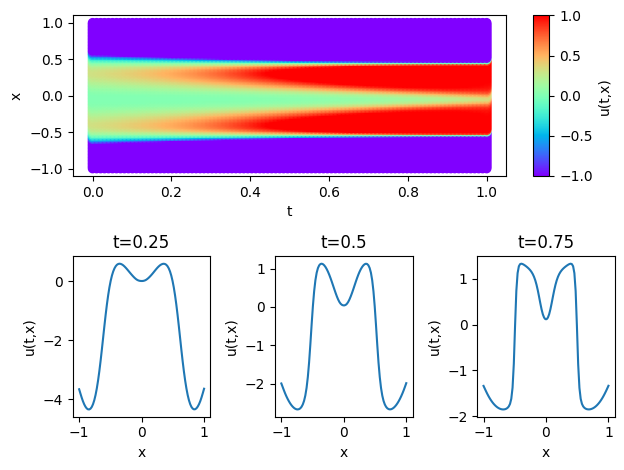

In [10]:
# visualization
epochs = config["train_epochs"]
visual(model, epochs=epochs, resolution=config["visual_resolution"])